In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Set up the reaction graph from DFT data 

In [29]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

#### 2. Sample the `graph`

In [62]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':5}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

1008it [00:54, 18.37it/s]                         


#### 3. generate reaction statistics

In [63]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(20)

1 H2 + 1 SO2 = 1 O2 + 1 H2S              554
1 H2O + 1 SO2 = 1 H2SO3                  395
2 H2 + 1 O2 = 2 H2O                      321
2 O2 + 1 H2S = 1 H2SO4                   284
3 H2 + 1 SO2 = 2 H2O + 1 H2S             225
3 O2 + 2 H2S = 2 H2O + 2 SO2             223
1 H2SO4 + 1 N2 = 1 H2S + 2 NO2           219
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4            184
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2           160
1 O2 + 1 H2S + 2 NO2 = 1 SO2 + 2 HNO2    147
16 H2O + 3 S8 = 16 H2S + 8 SO2           135
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO    115
2 H2 + 2 SO2 + 1 N2 = 2 H2S + 2 NO2       95
1 S8 + 8 NO2 = 8 SO2 + 4 N2               83
8 H2O + 1 S8 = 2 H2SO4 + 6 H2S            76
1 O2 + 2 H2O + 2 SO2 = 2 H2SO4            65
1 H2 + 1 NO2 = 1 H2O + 1 NO               64
1 H2O + 1 NO2 + 1 NO = 2 HNO2             60
8 O2 + 1 S8 = 8 SO2                       52
3 O2 + 2 H2S = 2 H2SO3                    51
dtype: int64

#### 4. generate mean concentrations and differences

In [64]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
print(average_data.round(2).to_string())

        initial   mean  diff   sem   std    var
O2         10.0   3.08 -6.92  0.07  4.39  19.28
H2S        10.0   4.18 -5.82  0.06  3.76  14.14
H2O        30.0  27.67 -2.33  0.08  5.30  28.06
NO2         5.0   2.85 -2.15  0.04  2.44   5.96
S8          0.0   0.00  0.00  0.00  0.00   0.00
NH3         0.0   0.09  0.09  0.01  0.55   0.30
NOHSO4      0.0   0.09  0.09  0.01  0.50   0.25
HNO3        0.0   0.17  0.17  0.01  0.65   0.42
HNO2        0.0   0.39  0.39  0.02  1.25   1.56
NO          0.0   0.39  0.39  0.02  1.29   1.67
N2          0.0   0.51  0.51  0.02  1.00   0.99
SO2        10.0  11.10  1.10  0.09  6.01  36.11
H2SO4       0.0   2.27  2.27  0.05  3.41  11.65
H2SO3       0.0   2.36  2.36  0.06  4.12  16.97
H2          0.0   3.07  3.07  0.06  4.21  17.75


#### 5. Plot 

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_30880/949321809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(name='RdBu')  # or any other colormap


<Axes: >

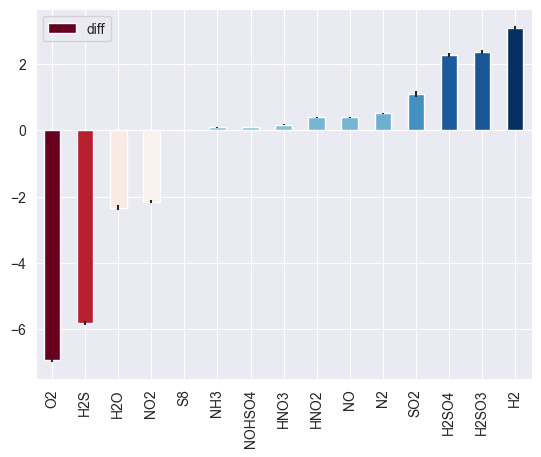

In [65]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [38]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white','directed':True}
g = analysis.result_to_pyvis(data,head=20,**pyvis_kwargs)
g.save_graph(name="example_pyvis_graph.html")

In [37]:
! open example_pyvis_graph.html